#**Final Project: Star Clusters, The Ultimate Laboratories for Stellar Astrophysics**

*Astronomy Goals*:

*   Plot color-magnitude diagrams (CMDs) for star clusters of different ages
*   Compare these CMDs to each other determine their relative ages
*   Use an isochrone stellar evolution model to age-date a star cluster

*Coding Goals*:

*   Download astronomy catalogs into Python (again)
*   Interact with and plot data from tables (again)
*   Save plots to your Google Drive





In [43]:
# We are going to save a plot to our Google Drive
# However, we only want to save the final product,
#   so we will create a True/False flag that will control
#   whether or not the figures are saved.

save_figures = False  # Only switch this to True when you are ready to save your figures.

# Once you have completed the assignment, set this to True and then rerun the entire notebook:
#   go to the "Runtime" drop-down menu and select "Run all".
# After the notebook runs through every step, go to your Google Drive folder and ensure that the figures were saved properly.

#**Background**

Stars form in clusters at approximately the same time and from the same material. While still gravitationally bound to their birth cluster, these stars then also share a common distance from Earth and pass through a similar amount of interstellar media (intervening gas and dust in the Galaxy, which dims and reddens starlight). For this reason, most of the variables governing a star's appearance and behavior are fixed, aside from mass (stars in binaries can also follow alternative evolutionary pathways; the initial rotation rate also matters). This makes star clusters potentially valuable laboratories for studying stars. "Potentially," because before we can do anything else we first must do the hard work of thoroughly characterizing the cluster and identifying its members.

Star clusters were historically identified as overdense groupings of stars on the sky (e.g., the Pleiades). Now that we have precise astrometric data from Gaia, we can use the parallaxes and proper motions (angular velocities across the sky) to identify with more confidence the members of known star clusters and even to discover new ones. To be identified as a star cluster, the stars are generally found to be at the same distance from Earth and moving together through the Galaxy. To remain gravitationally bound to each other, their spread in velocities must not be too great, otherwise their kinetic energies will exceed their gravitational potential energies and they will escape from the cluster. This makes parallaxes and proper motions very useful quantities for this work.

Since Gaia's second data release (DR2, back in 2018), many teams around the world have mined its astrometric database to identify clusters and their members. In this project, we will use catalogs assembled by Cantat-Gaudin et al. (2020) and published in the journal *Astronomy & Astrophysics* in [*Painting a portrait of the Galactic disc with its stellar clusters*](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A...1C/abstract). We will load catalogs for a variety of nearby star clusters (some of those within 1000 pc), put together their color$-$magnitude diagrams (CMDs), and then use these to explore some basic properties of star clusters before ultimately deriving an age for one.

#**Setting up our notebook**

We'll start by importing the Python modules we have been using. These should look familiar by now!

In [1]:
# Numpy: arrays, numbers, constants, math
import numpy as np

# Matplotlib: plotting
import matplotlib.pyplot as plt

# This disables certain system messages
import warnings
warnings.filterwarnings('ignore')

# Accessing astronomical datasets
!pip install astroquery
from astroquery.vizier import Vizier

# Reading and working with Astropy tables
from astropy.io import ascii

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 16.6 MB/s eta 0:00:00


**Mount your Google Drive**

Your Google Drive can be accessed from this Jupyter Notebook. Files can be read into your session, and files can be written and saved for later (e.g., plots). This is a very important ability, so we will introduce one example in this assignment: saving a plot you create to a *.png file.

To gain this ability, we must give our permission. Running the cell below will print a URL. Clicking on this should launch a new tab, where you can select your Google account and sign in. This will provide an authorization code: you can either highlight it with your mouse and copy it, or you can click the box icon to the right of the code and it will copy for you. Close the tab and come back to this notebook and paste the code in the box provided below (it will say, "Enter your authorization code:"). You can either paste using the drop-down menu under "Edit" in this notebook, or you can use your standard keyboard shortcuts (e.g., for Mac users, command+v will paste).

While we're on the subject of keyboard shortcuts, familiarizing yourself with certain commands will improve your working efficiency. For example (for Mac users), you can run a code cell by entering command+return, you can add a new cell by holding command and pressing m then b, and you can delete a cell by holding command and pressing m then d. The drop-down menus provide some other handy shortcuts.



In [5]:
# You have to give permission to the notebook to access files stored in your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**Create a folder for this course and for your figures**

If you have not already, it is a good idea to create a folder for this course in your Google Drive. You can place these assignment notebooks there, which will be useful when you find yourself trying to hack some code in the future. We will also save figures to this folder in this assignment.

Let's say you add a folder in the main level of your Google Drive called "Astro_Course." It will be located in the following folder location (this can also be referred to as a directory or path):

In [6]:
my_folder_name = 'Astro_Course'

main_level = '/content/gdrive/My Drive/'

my_folder = main_level + my_folder_name + '/'

print(my_folder)

/content/gdrive/My Drive/Astro_Course/


In [7]:
# Test if you have created this directory:
from glob import glob
path_to_your_folder = glob(my_folder)
if np.size(path_to_your_folder) == 0:
  print('Please create your folder.')
  print('Once you have done this, rerun the notebook from the top (e.g., "Runtime --> Run all").')
  my_folder = main_level
  print('For now, figures will be saved to the main level of your Google Drive: '+main_level)
else:
  print('Your working directory is set to ',my_folder)

Your working directory is set to  /content/gdrive/My Drive/Astro_Course/


#**Obtaining the Gaia star cluster catalogs**

If you follow the link to [*Painting a portrait of the Galactic disc with its stellar clusters*](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A...1C/abstract) you will reach its ADS entry. ADS, the astrophysics data system, is an extremely useful repository of journal articles, where you can find just about every astronomy publication's abstract, links to the PDF or HTML versions of the paper (or scans of its pages, for the very old ones), and in some cases, a button under "Data Products" labeled "CDS."

CDS stands for the Centre de Données astronomiques de Strasbourg, located in France, which is one of the biggest online data archives for astronomy. There, we can access the data table for the Cantat-Gaudin et al. paper and many other datasets as well. The Python $\texttt{astroquery}$ package includes a tool for accessing datasets stored at CDS, including on its VizieR and SIMBAD archives.

**A function to download the catalog for a particular cluster**

The code cell below defines a function, $\texttt{get_cluster}$, which downloads the membership list for a given star cluster from the Cantat-Gaudin et al. (2020) catalog. The user (you!) must provide the cluster name as a string (that means the name must be wrapped in quotes). Furthermore, the cluster name must match the catalog's format. For one, the catalog uses an underscore instead of whitespace. For example, the cluster NGC 2682 is listed as "NGC_2682."

In [11]:
def get_cluster(Cluster_Name):
  vizier_CantatGaudin2020 = 'J/A+A/640/A1/nodup'    # Cantat-Gaudin et al. (2020) - this is the vizier code for the "Portrait" paper.

  # Set up the Vizier query.
  # First, we want to select only stars in the cluster we are interested in.
  # Second, Cantat-Gaudin+2020 also provides membership probabilities (ranging from 0 to 1).
  #   We will only download stars with membership probabilities greater than 50%.
  query_catalog = Vizier(column_filters={'Cluster': Cluster_Name, 'prob':'>0.5'})

  # By default, Vizier() only downloads the first 50 rows of a table.
  # To deactivate the row limit, set it to -1 (i.e., this will tell it to download the full table)
  query_catalog.ROW_LIMIT = -1

  # Perform the query
  cluster_catalog = query_catalog.get_catalogs(vizier_CantatGaudin2020)[0]

  # Rename some of the columns to simpler names
  cluster_catalog['pmRA_'].name = 'pmRA'
  cluster_catalog['pmDE'].name = 'pmDec'
  cluster_catalog['Plx'].name = 'Parallax'
  cluster_catalog['RA_ICRS'].name = 'RA'
  cluster_catalog['DE_ICRS'].name = 'Dec'

  # Remove some unnecessary columns
  cluster_catalog.remove_columns(['o_Gmag', 'proba', 'Cluster', '_RA.icrs', '_DE.icrs','Teff50'])

  # Return the catalog
  return cluster_catalog

**Example: Downloading the catalog for the Praesepe cluster (NGC 2632)**

Below, we are going to download the Cantat-Gaudin et al. (2020) catalog for Praesepe, the Beehive Cluster, a well-known cluster in the constellation of Cancer. In Cantat-Gaudin et al., Praesepe is listed as NGC 2632. As you will have gathered, many clusters have multiple names; Praesepe is also known as M44 and Cr 189, for example. We are going to refer to this cluster and others in this project by the name most commonly used by modern astronomers*, but note that Cantat-Gaudin and others often use alternative names (just another example of nomenclature fun in astronomy!).

The NGC designation, by the way, is from the *New General Catalogue of Nebulae and Clusters of Stars*, which was published at the end of the 19th century, but built on work done by the Herschel family starting a century earlier. William and his sister Caroline put together a *Catalogue of Nebulae and Cluster of Stars* in 1786; John, William's son, published the *General Catalogue of Nebulae and Clusters of Stars* in 1864. The next step is obviously to put out the VNGC, the *Very New General Catalogue.*

**by which I mean my collaborators and myself*

In [9]:
# Download the data table for Praesepe, aka NGC 2632:
Praesepe = get_cluster('NGC_2632')

# Typing the name of a table (or any object) prints out the contents (or a summary of the contents for large collections like this one).
Praesepe

RA,Dec,GaiaDR2,Parallax,pmRA,pmDec,RV,Gmag,BP-RP,Simbad
deg,deg,,mas,mas / yr,mas / yr,km / s,mag,mag,
float64,float64,int64,float64,float64,float64,float64,float64,float64,str6
130.96559423303,17.65554345030,658570974996041344,5.5616091719566381,-36.0951463406403263,-11.4647544371596481,--,16.9278300,2.7468777,Simbad
130.28844967979,17.57132332981,658602070559194496,5.1902136361683775,-37.6735381214203713,-12.1980020122218686,--,17.9982280,3.033121,Simbad
130.41020914491,17.63997442869,658607950370340608,5.3420907729709839,-36.1697829975305183,-11.4013086809733295,--,14.5262630,1.9543886,Simbad
130.35880803061,17.80347466009,658615440793299712,5.525517862750517,-37.2407743397463591,-11.7723426012894397,--,16.5640830,2.7845163,Simbad
131.04968310132,17.90213538700,658628905514597376,5.2502808479682859,-35.8790774968654063,-11.4402870923511379,35.4208499056807539773,9.8143340,0.6274204,Simbad
130.57294256495,17.98745732057,658641996575437440,5.4342666227954171,-36.4579927840668532,-11.5855386597088703,--,16.6756610,2.7992096,Simbad
130.94716498833,18.04997813564,658645574283870720,5.6033780118328504,-37.1616182148293959,-11.6285410147178609,--,17.3063720,3.0871773,Simbad
129.30751563824,17.51348567905,659248858275152128,5.2896850519082337,-35.4394605979004069,-11.7257846800733034,--,13.2668460,1.4617271,Simbad



The cluster name is provided as a string (in quotes), and the function returns the data table. You can see that the first line printed is *Table length=685*. This tells you that there are 685 stars for this particular cluster in this particular catalog.

A fun fact that is entirely irrelevant for this project, but that turns out to be very important in practice, is that different authors will apply different membership criteria when constructing catalogs, and will therefore find differing numbers of members *for the same cluster*. This means that one of the first job when studying a cluster is to decide how to reconcile various catalogs.

**Column descriptions**

We have already seen many of these data types, but just to remind you, here is what you are getting:

*   *RA, Dec*: Equatorial coordinates of Right Ascension and Declination, measured in decimal degrees (RA goes from 0 to 360$^\circ$, and Dec goes from $-$90 to 90$^\circ$). These are the angular sky coordinates.
*   *GaiaDR2*: The Gaia Source ID number from the second data release catalog. This is a unique identifier for each star in the catalog.
*   *Parallax*: The parallax, measured in mas (1/1000 of an arcsecond), can be inverted to estimate the distance to a source.
*   *pmRA, pmDec*: The proper motion in the RA and Dec directions, measured in mas per year. These are angular velocities of the stars across the sky.
*   *RV*: radial velocity, the speed of the stars along the line of sight, measured in km/s.
*   *Gmag*: The apparent $G$ magnitude.
*   *BP-RP*: The Gaia color, calculated by subtracting the $RP$ magnitude from the $BP$ magnitude (review Assignment 2 for more information).

Note that the units are provided under the table column names.

**Using data in a table**

Review Assignment 3 for an example of using an astropy table, like this one, to access and plot data.




#**Section 1: Plotting the CMD for Praesepe**
Praesepe, the Beehive Cluster, is a well-known cluster in the constellation of Cancer. In fact, it is one of the first objects Galileo observed when he started observing celestial objects with his telescope. Somewhere I have a picture I took of his representation of the cluster in *Sidereus Nuncius* (1610), the Starry Messenger---Columbia's Rare Book and Manuscript Library has an original edition, and believe it or not, they will let you borrow it! I can't find that picture right now, so below is one I stole from the internet.

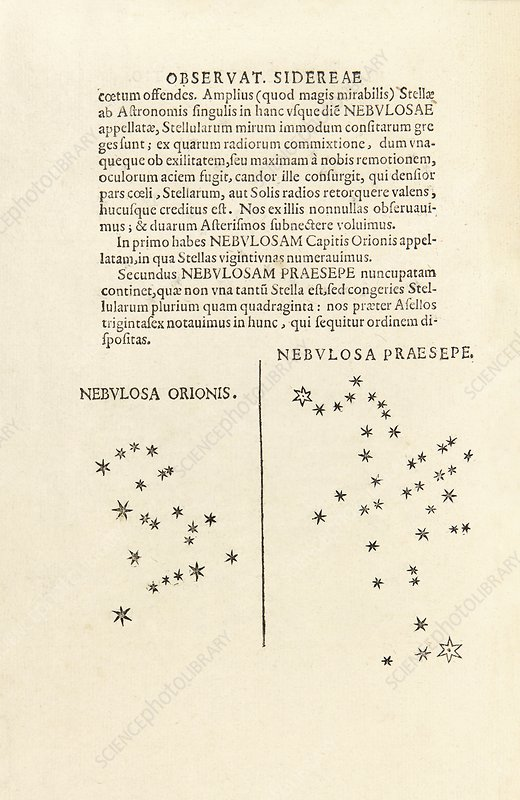

Because it is nearby and had a pretty extensive set of members, 400 years on, Praesepe remains one of the benchmark clusters for stellar astrophysics.

In [14]:
# How many stars are in this catalog for Praesepe?
#685
# We know the answer because it is printed above, but how do you calculate it?

#use the len function to find the length of Praescepe object
n_stars = len(Praesepe)
print(n_stars)

685


**Plot the CMD**

The CMD is the starting point for virtually all investigations involving a stellar population. Here we will start by plotting our standard *Gaia* $G$ vs $BP-RP$ CMD, using the apparent $G$ magnitude. The code cell below provides an outline for you. Fill in the needed pieces to make the figure.

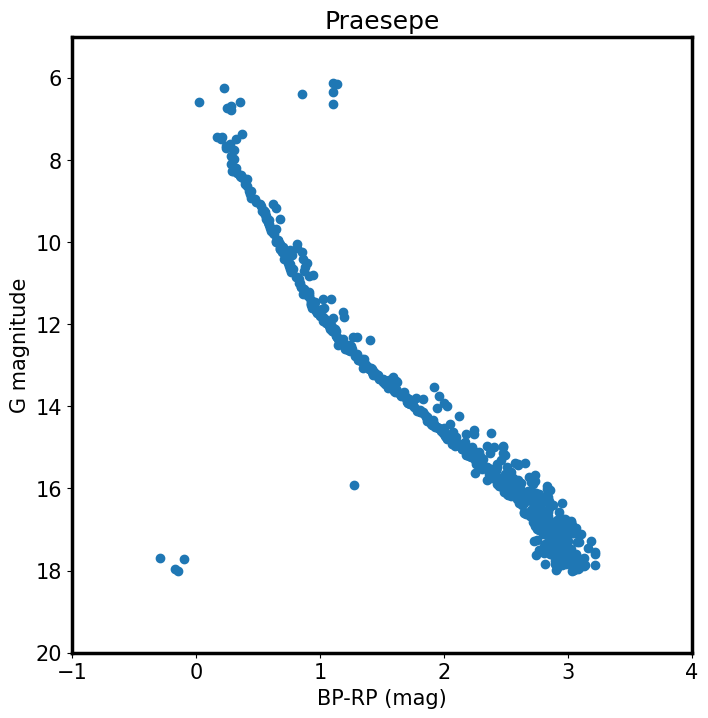

In [27]:
##### Plot BP-RP vs Gmag #####
BPRP = Praesepe['BP-RP'].data
Gmag = Praesepe['Gmag'].data

### Make a nice canvas for the figure
figure, axis = plt.subplots(figsize=(8,8))

### Add the data
axis.scatter(BPRP, Gmag)

### Set the x and y limits
# axis.set_xlim() # after you plot the full sample, choose a minimum and maximum BP-RP and activate this line
# axis.set_ylim() # same but for Gmag; recall that bright stars go on top and faint stars go on the bottom of a CMD
axis.set_xlim(-1,4)
axis.set_ylim(20,5) # Inverted y-axis

### Add axis labels & title
axis.set_xlabel('BP-RP (mag)', fontsize=15)
axis.set_ylabel('G magnitude', fontsize=15)
axis.set_title('Praesepe', fontsize=18)

# Make plot look nice
axis_border_width = 2.5
fontsize_axis_labels = 15
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)

# If you want to save this figure, you can place your figure.savefig() command here.
# It is not required for this assignment.
# Show the figure
figure.show()


Your figure should look like this: 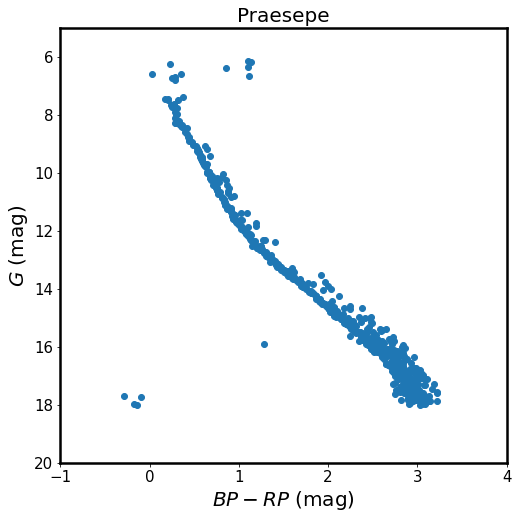

**Question**$-$In a few sentences, explain why is it OK for us to plot apparent $G$, rather than absolute $G$, in this CMD.

> Plotting the apparent G magnitude instead of the absolute G magnitude in this CMD is okay for a stellar cluster like Praesepe because all the stars in the cluster are at approximately the same distance from us. Because of this approximate same distance, the G alone will be sufficient in seeing the realtive brightness and temps of the stars.

There are two ways to mathematically justify your answer. One is to calculate the physical depth of the cluster and compare it to the median distance of its members from Earth. The other, which is more statistically sound, is to estimate the standard deviation of the distance distribution and compare that to the median distance of Praesepe's members from Earth.

In [25]:
# Calculate the physical depth of Praesepe and compare it to the cluster's median distance from Earth
parallax_mas = Praesepe['Parallax'].data
parallax_arcsec = parallax_mas / 1000.0
distance_pc = 1.0 / parallax_arcsec

# farthest and closest star
max_distance = np.max(distance_pc)
min_distance = np.min(distance_pc)

physical_depth = max_distance - min_distance

#median distance
median_distance = np.median(distance_pc)

# Print
print(f"Median Distance from Earth: {median_distance} parsecs")
print(f"Cluster's Depth: {physical_depth} parsecs")

comparison = physical_depth/median_distance
print(f"Cluster's Depth compared to Median Distance : {comparison}")

Median Distance from Earth: 186.89631679252963 parsecs
Cluster's Depth: 27.166065036327808 parsecs
Cluster's Depth compared to Median Distance : 0.1453536672233321


In [26]:
# Calculate the standard deviation of the distance distribution of Praesepe stars and compare it to the cluster's median distance from Earth

# Calculate the std
std = np.std(distance_pc)
# Comparing the depth to median distance
comparison = std/median_distance
print(f"Median Distance from Earth: {median_distance} parsecs")
print(f"Standard Deviation : {std} parsecs")
print(f"Std compared to Median Distance: {comparison}")

Median Distance from Earth: 186.89631679252963 parsecs
Standard Deviation : 4.923910264657731 parsecs
Std compared to Median Distance: 0.026345678444394803


**Question**$-$What can you conclude?

> the physical depth of the cluster (from the closest to the farthest star) is about 14.5% of the median distance to the cluster. This ratio suggests that the cluster is relatively small in comparison to its overall distance from Earth.  The standard deviation, is 2.6% of the median distance, this ratio, compared to the physical depth, indicates a high degree of uniformity in the distances of the stars from Earth. Both methods illustrate that Praesepe is a relatively compact cluster, and that it is safe to use G in our CMD, instead of absolute magnitude. The standard deviationn serves use better because it also tells us about the spread of the cluster itself.

#**Section 2: Comparing apparent and absolute magnitude CMDs: the Hyades**
The Hyades, in Taurus, is another benchmark cluster, largely because of its proximity to Earth. In the catalog, the Hyades cluster is called "Melotte_25". Download the cluster and plot its apparent CMD next to its absolute CMD.

Philibert Jacques Melotte was a British (no, really) astronomer who published a catalog of star clusters in 1915. It drives me a little crazy when people refer to well-known star clusters like the Hyades (an object you can see with your eyes...!) by their Melotte catalog number, but anyway. Using catalog numbers is definitely easier than using historical names when coding things up.

In [28]:
# Download the Hyades catalog (listed as "Melotte_25")
Hyades = get_cluster('Melotte_25')
Hyades

RA,Dec,GaiaDR2,Parallax,pmRA,pmDec,RV,Gmag,BP-RP,Simbad
deg,deg,,mas,mas / yr,mas / yr,km / s,mag,mag,
float64,float64,int64,float64,float64,float64,float64,float64,float64,str6
58.14384068368,11.26075026068,36629890579758592,28.598377211962266,176.685799845052827,-8.66674604583512931,--,12.6262080,2.5727358,Simbad
59.56042372775,12.62797069843,38329666836450304,21.946148203838629,129.43544721820507,-12.3098653639171651,--,15.1111560,3.2145452,Simbad
58.75658414086,12.48554217275,38354680725946240,21.721822994255881,131.227555460096823,-10.2290840289827329,36.3159809099714152580,9.7661130,1.2956991,Simbad
58.44437807278,13.39192671281,38670343642226816,24.153702243865073,148.357283332882758,-13.9080532784734441,--,14.8321440,3.2003345,Simbad
60.18786450237,13.90626330846,38929141191925760,21.241980830622829,128.29540630275045,-16.1790403778897591,--,13.3299740,2.986785,Simbad
60.92600247350,14.99122205563,39305036729495936,24.052709700794892,141.189959131320933,-24.0698230311297365,--,15.0388500,-0.12748432,Simbad
58.72235328058,16.31552394857,40470720915966208,22.731166522828545,134.275203827943386,-22.675896752658943,--,12.9574770,2.851059,Simbad
53.14433967637,16.15326441014,42716408993806080,20.533852313612218,141.082307465623273,-14.6922463779179999,32.8128713016390207713,12.9808000,2.7437143,Simbad


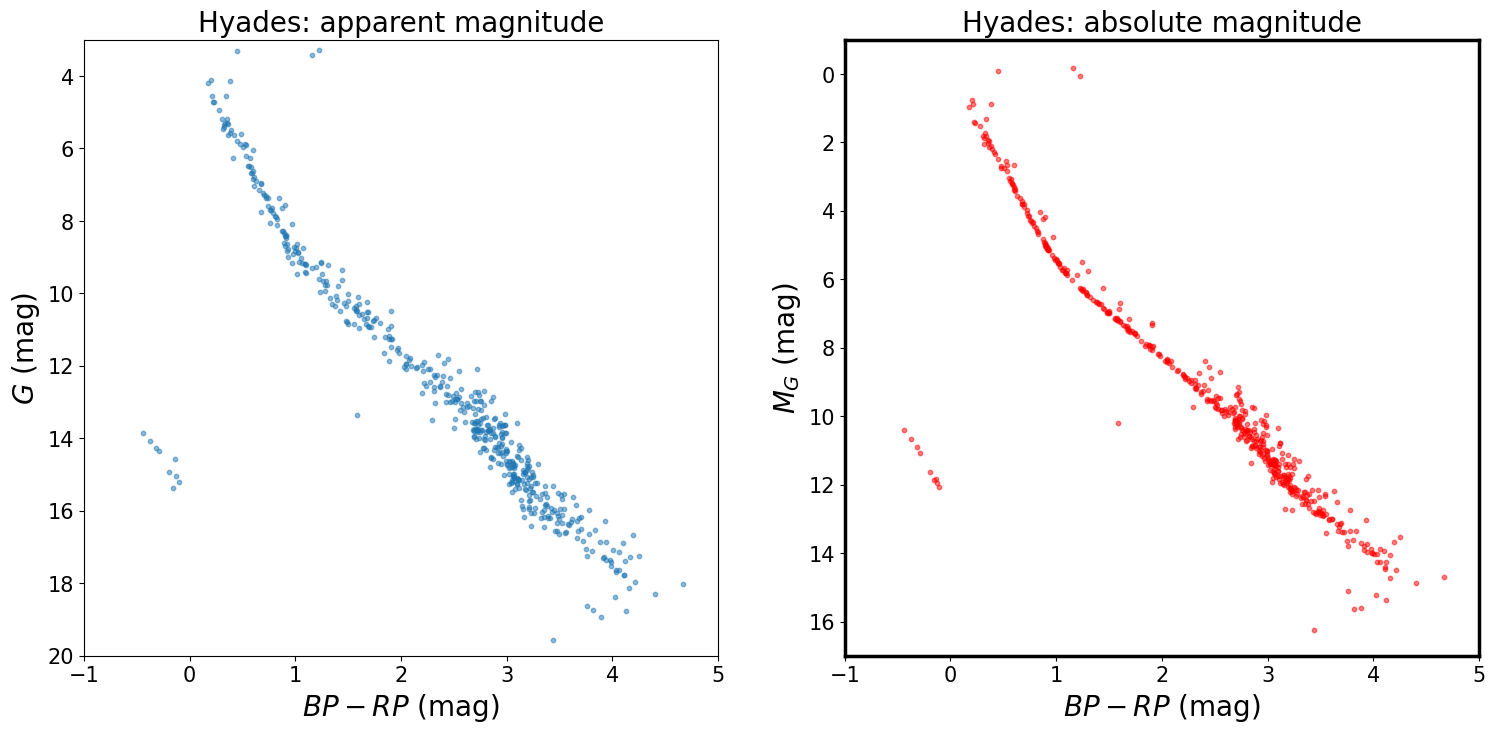

In [46]:
# Plot side-by-side the apparent-G CMD and absolute-G CMDs:
BPRP = Hyades['BP-RP'].data  # Replace with actual data extraction
apparent_mags = Hyades['Gmag'].data     # Replace with actual data extraction

# Make a nice canvas for the side-by-side figure
figure, (axis_apparent, axis_absolute) = plt.subplots(1,2, figsize=(18,8)) # here we make a grid of panels: 1 row x 2 columns.
# To work on the left panel, use the axis_apparent object following the guidance below; for the right panel use axis_absolute.

# Add titles to each panel:
axis_apparent.set_title('Hyades: apparent magnitude',fontsize=20)
axis_absolute.set_title('Hyades: absolute magnitude',fontsize=20)

# Add the apparent-G CMD: BP-RP vs Gmag
axis_apparent.scatter(BPRP, apparent_mags, s=10, alpha=0.5)

# Add the absolute-G CMD: BP-RP vs M_G

# Parallax in milliarcseconds
parallax_mas = Hyades['Parallax'].data
# Ensure that parallax values are non-zero
parallax_mas[parallax_mas == 0] = np.nan
# Calculate distance in parsecs (conversion from mas to arcseconds)
distance_parsec = 1000 / parallax_mas

# Calculate absolute magnitudes  M_G =   # create a variable called M_G which will be the absolute magnitudes for the Hyades
M_G = apparent_mags - 5 * (np.log10(distance_parsec) - 1)
# Plot BP-RP vs M_G:
axis_absolute.scatter(BPRP, M_G, s=10, alpha=0.5, color='red')

# After you have run the cell with the plots, set the x and y limits for each panel and rerun.
# Apparent: Set the x and y limits
axis_apparent.set_xlim(-1,5)
axis_apparent.set_ylim(20,3)

# Absolute: Set the x and y limits
axis_absolute.set_xlim(-1,5) # This should be the same as the left panel
axis_absolute.set_ylim(17,-1) # But this will be different


# Apparent: Add axis labels
axis_apparent.set_xlabel('$BP - RP$ (mag)', fontsize=20)
axis_apparent.set_ylabel('$G$ (mag)', fontsize=20)

# Absolute: Add axis labels
axis_absolute.set_xlabel('$BP - RP$ (mag)', fontsize=20)
axis_absolute.set_ylabel('$M_G$ (mag)', fontsize=20)


# Make plot look nice
axis_border_width = 2.5
fontsize_axis_labels = 15
axis_apparent.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis_apparent.spines['top']
axis_apparent.spines['left']
axis_apparent.spines['right']
axis_apparent.spines['bottom']
# Copy the five lines above and paste them below this line,
axis_absolute.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis_absolute.spines['top'].set_linewidth(axis_border_width)
axis_absolute.spines['left'].set_linewidth(axis_border_width)
axis_absolute.spines['right'].set_linewidth(axis_border_width)
axis_absolute.spines['bottom'].set_linewidth(axis_border_width)
#   then modify the axis names to make the right-hand panel bold.


# Conclude the figure
figure.show()

**Question**$-$In a few sentences, explain why, in this case, the apparent magnitude and absolute magnitude CMDs do not look all that similar.

> The absolute magnitude CMD better reflects the intrinsic properties of stars, but the apparent magnitude CMD is also dependent on their distance to the earth. Therefore the apparent CMD has the higher magnitudes, since absolute magnitude is calculated at 10 parces, and the cluster is further than 10pc, therefore it will be dimmer and have higher apparent magnitudes. The absolute magnitude CMD will show better the actual properties of the star, not dependent on its distance to earth, and will be brighter, therefore have a lower magnitudes.


**Main sequence outliers**

In the right panel, the absolute CMD shows a main sequence that is much tighter than is found by simply plotting the apparent $G$ magnitudes. In fact, the main sequence looks like someone drew a curve on the screen with a marker. However, there are some noteable outliers.

**Question**$-$What are the stars at ($BP-RP$, $M_G$) = (1, 0)?

> Those are giants, possibly red giants

**Question**$-$What is that line of stars in the lower left corner (blue and faint)?

> white dwarfs

The outliers that are probably *hardest* to interpret are the ones that sit just above the main sequence. For example, at $BP-RP$ = 2, the main sequence has a value of about $M_G = 8$ mag, but there is a star with a slightly smaller $M_G$ at that same color. In other words, this star is brighter than you would expect given its color, which is a telltale sign of an unresolved binary: two stars close enough together that the photometric measurement cannot distinguish them.

**Question**$-$If the two stars that make up the binary system have the same mass, and therefore the same luminosity, use the relationship between flux and magnitude to show that you expect the offset between the unresolved binary system and a main-sequence star of the same color to be approximately 0.75 mag.

In [38]:
# what is the magnitude offset of a binary where the component stars are equally bright?
    #if the flux of a single star is F, then the flux of two of these stars is 2*F, using the magnitude and flux formula m=-2.5*log(2F) to find the offset
# Magnitude offset for a binary system where component stars are equally bright
magnitude_offset = -2.5 * np.log10(2)
magnitude_offset


-0.752574989159953

Later on you will be fitting isochrones to the CMDs of various clusters. Keep in mind when doing so that what you want to fit (to the extent possible) is *the single star main sequence*, i.e., the sequence that forms the bottom edge of the main sequence. Binary stars, which give the main sequence its thickness, can evolve quite differently from single stars (because of mass transfers), and therefore are not as reliable an indicator of the age of the cluster.

#**Section 3: Comparing CMDs for clusters young and old**

Plot absolute $M_G$ CMDs *on one figure* for the following clusters:

1.   Pleiades ("Melotte_20")
2.   M48 ("NGC_2548")
3.   NGC 6811 ("NGC_6811")
4.   NGC 752 ("NGC_752")
5.   M67 ("NGC_2682")

It is hard to keep track of these various names, but it is also useful if you can! These are some of the most important benchmark clusters in astrophysics, and they come up in casual conversations all the time (well, among some people).

To overlay multiple plots on one figure panel, simply add multiple plot() or scatter() commands. By default, the colors will cycle through a series; you can also reset the color manually using the keyword c='red' or an alternative color. For a list of color options, you can Google "matplotlib colors."

**Get catalogs for the clusters**

In [40]:
# Pleiades (listed as "Melotte_20")
Pleiades = get_cluster('Melotte_20')

# M48 (listed as "NGC_2548")
M48 = get_cluster('NGC_2548')

# NGC_6811 (listed as "NGC_6811")
NGC_6811 = get_cluster('NGC_6811')

# NGC_752 (listed as "NGC_752")
NGC_752 = get_cluster('NGC_752')

# M67 (listed as "NGC_2682")
M67 = get_cluster('NGC_2682')

**Plot the CMDs for these clusters in one panel**

Add a legend to the figure that maps point color to cluster name. The code that creates the legend is provided. To make it work, a label keyword must be added to each cluster's axis.scatter() command like so:

> $\texttt{axis.scatter(x_data, y_data, label="Here is my legend label")}$

Once each label is added to the axis.scatter() commands, then axis.legend() will do the rest.



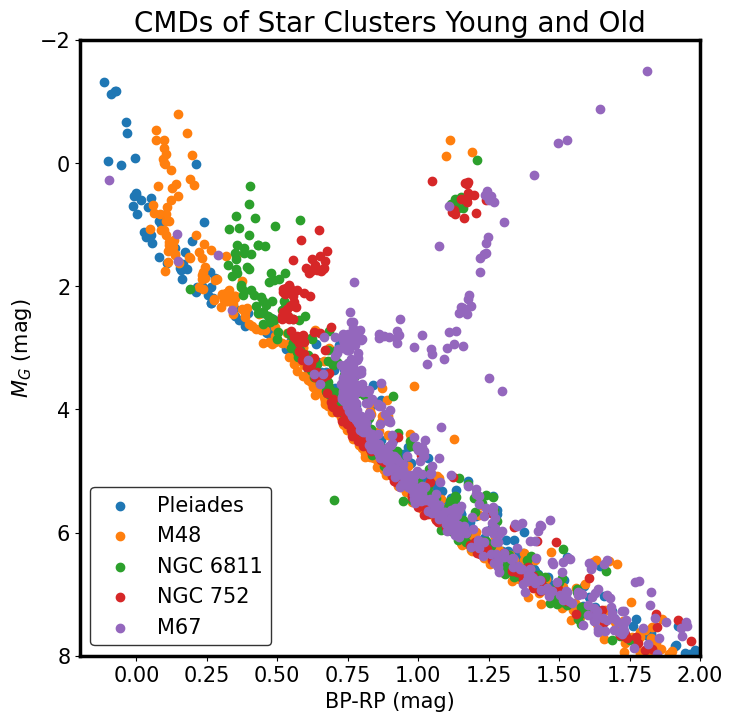

In [58]:
# Plot the CMDs for the above clusters:

# Make a nice canvas for the figure
figure, axis = plt.subplots(figsize=(8,8))

# Add title
axis.set_title('CMDs of Star Clusters Young and Old',fontsize=20)

# Add Pleiades: plot the absolute-G CMD: BP-RP vs M_G (not just Gmag)

BPRP = Pleiades['BP-RP'].data
apparent_mags = Pleiades['Gmag'].data
parallax_mas = Pleiades['Parallax'].data
parallax_mas[parallax_mas == 0] = np.nan
distance_parsec = 1000 / parallax_mas
M_G = apparent_mags - 5 * (np.log10(distance_parsec) - 1)
axis.scatter(BPRP, M_G, label='Pleiades')

# Remember to add a legend label to your CMD: axis.scatter(x_data, y_data, label='Here is my legend label')

# Add M48: plot the absolute-G CMD: BP-RP vs M_G
BPRP = M48['BP-RP'].data
apparent_mags = M48['Gmag'].data
parallax_mas = M48['Parallax'].data
parallax_mas[parallax_mas == 0] = np.nan
distance_parsec = 1000 / parallax_mas
M_G = apparent_mags - 5 * (np.log10(distance_parsec) - 1)
axis.scatter(BPRP, M_G, label='M48')

# Add NGC 6811: plot the absolute-G CMD: BP-RP vs M_G
BPRP = NGC_6811['BP-RP'].data
apparent_mags = NGC_6811['Gmag'].data
parallax_mas = NGC_6811['Parallax'].data
parallax_mas[parallax_mas == 0] = np.nan
distance_parsec = 1000 / parallax_mas
M_G = apparent_mags - 5 * (np.log10(distance_parsec) - 1)
axis.scatter(BPRP, M_G, label='NGC 6811')

# Add NGC 752: plot the absolute-G CMD: BP-RP vs M_G
BPRP = NGC_752['BP-RP'].data
apparent_mags = NGC_752['Gmag'].data
parallax_mas = NGC_752['Parallax'].data
parallax_mas[parallax_mas == 0] = np.nan
distance_parsec = 1000 / parallax_mas
M_G = apparent_mags - 5 * (np.log10(distance_parsec) - 1)
axis.scatter(BPRP, M_G, label='NGC 752')

# Add M67: plot the absolute-G CMD: BP-RP vs M_G
BPRP = M67['BP-RP'].data
apparent_mags = M67['Gmag'].data
parallax_mas = M67['Parallax'].data
parallax_mas[parallax_mas == 0] = np.nan
distance_parsec = 1000 / parallax_mas
M_G = apparent_mags - 5 * (np.log10(distance_parsec) - 1)
axis.scatter(BPRP, M_G, label='M67')

# Add a legend
axis.legend(loc='lower left', fontsize=15, edgecolor='black')

# Set the x and y limits
axis.set_xlim(-0.2, 2.0)
axis.set_ylim(8,-2)

### Add axis labels & title
axis.set_xlabel('BP-RP (mag)', fontsize=15)
axis.set_ylabel('$M_G$ (mag)', fontsize=15)

# Make plot look nice
axis_border_width = 2.5
fontsize_axis_labels = 15
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)


# Save the figure to your drive
if save_figures == True:
  file_name = my_folder + "CMDs_of_Clusters_Young_and_Old.png"
  figure.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0.25, transparent=False)

# Conclude the figure
figure.show()

This exercise reproduces a classic figure by Johnson & Sandage, which appeared in a few varieties during the 1950s; see, for example, [*The galactic cluster M 67 and its significance for stellar evolution*](https://ui.adsabs.harvard.edu/abs/1955ApJ...121..616J/abstract) (Johnson & Sandage 1955), and [*The Color-Magnitude Diagrams of Galactic and Globular Clusters and their Interpretation as Age Groups*](https://ui.adsabs.harvard.edu/abs/1958RA......5...41S/abstract) (Sandage 1958). Take a look$-$your plot should look similar! Of course, the data that you are using are far superior to what was available back in the 1950s...

**Question**$-$In a few sentences, describe the main differences between the clusters you have plotted.

> the main differences shown here point to the different stars because of the age of the clusters plotted. PLeidas being a younger cluster, has stars on the main sequence with hotter, more luminous blue stars, whereas older clusters like M67 show more evolved stars, hence it has a red giant branch. Because of difference in ages, we also see different main sequence turn off points; young clusters have turn off points that are high in the CMD, higher on the main sequence, while the older ones have it a dimmer magnitudes, lower on the CMD.

**Question**$-$Several of these clusters have giants, but only one has subgiants. Which one? Why is it the only cluster with subgiants?

> M67 is the oldest of the clusters shown, and thus since it an old open cluster, its stars have evolved off the main sequence and have been able to go through a giant phase, where as the other clusters included are relativelty young compared to M67.

**Question**$-$In a few sentences, explain why the stars for all the clusters overlap for colors $BP-RP > 0.75$ and magnitudes $M_G > 4$.

> TThis overlap is from low mass stars that all on the same section of the main sequence. Because these low mass stars have such long lifetimes, they are relatively are on the same spot on the CMD, regardless of how old their respective cluster may be.

#**Section 4: Overlaying an isochrone on a cluster of your choice to derive its age**
Isochrones are stellar evolution models that tabulate a star's fundamental properties (e.g., luminosity, surface gravity, effective temperature) and observable properties (photometric color and absolute magnitude) at a specific age for a range of masses. The models are initialized at an early age and then evolved forward in time. When you plot an isochrone, you are therefore predicting where all of the stars in a population of a given age should lie on a CMD.

One popular isochrone model is called PARSEC, and can be queried from a website: http://stev.oapd.inaf.it/cgi-bin/cmd_3.6

To simplify the process, we queried the PARSEC isochrone model by selecting the appropriate photometric system (Gaia DR2 with Evans+2018 passbands), with zero interstellar extinction, solar metallicity, and ages ranging from 100 Myr to 10 Gyr logarithmically spaced by 0.02 dex (i.e., log ages range from 8.0 to 10.0 with steps of 0.02). We then modified the resulting file by renaming a few columns to be more easy to interpret, deleting unneeded columns, and removing the # hashtag at the row line that has the column names so that it can be more easily read into Python using the tools we are familiar with. We then placed this file online so that it can be accessed.

**Load the Gaia DR2 isochrone**

In [59]:
# The URL where we have placed the modified isochrone file
url = "https://github.com/jasoncurtis/Lessons/blob/main/GaiaDR2_Isochrones.dat?raw=true"
# Read the file using astropy.ascii.read()
isochrone_table = ascii.read(url, delimiter=r'\s')

**Define some useful functions for working with isochrones**

In [60]:
# Define a function that locates the place in an array where the entry is closest to a requested value:
def find_element(value, array):
  absolute_difference = abs(array - value)
  location_of_element_nearest_to_value = np.argmin(absolute_difference)
  return location_of_element_nearest_to_value

In [62]:
# Define a function that pulls out one isochrone (one age) out of the grid.

# This function will also introduce interstellar extinction (dims Gmag) and reddening (increases BP-RP).
# This is parameterized with $A_V$, the extinction in the visual $V$ band.
# The extinction in other bands can be calculated from A_V using "extinction coefficients"


def get_isochrone(age, Av = 0.0):
  # Note: Input age must be in millions of years (Myr)

  #finds the unique ages on the ischrone table
  unique_ages_in_isochrone_table = np.unique(isochrone_table['log_Age'])

  #lcoate the nearest age in the isochrone table
  location_of_nearest_age_in_isochrone = find_element(age, 10**unique_ages_in_isochrone_table/1e6)

  #extract this nearest age in the isochrone
  nearest_age_in_isochrone = unique_ages_in_isochrone_table[location_of_nearest_age_in_isochrone]

  # given the nearest age, find duplicates of this age,
  find_matching_ages = np.where((isochrone_table['log_Age'] == nearest_age_in_isochrone) &
                                (isochrone_table['label']<7)
                                )[0]

  # extract isochrone at the given age
  isochrone_at_input_age = isochrone_table[find_matching_ages]

  #find the gai color BPRP
  isochrone_at_input_age['BP-RP'] = isochrone_at_input_age['G_BPmag'] - isochrone_at_input_age['G_RPmag']

  # Correct photometry for interstellar reddening and extinction
  isochrone_at_input_age['Gmag'] += 0.86*Av
  isochrone_at_input_age['BP-RP'] += 0.415*Av

  #remove the unneeded columns
  isochrone_at_input_age.remove_columns(['G_BPmag', 'G_RPmag'])

  # return
  return isochrone_at_input_age



**Correcting for extinction and reddening caused by interstellar dust**

The above function can also add interstellar extinction (dims $G$ mag) and reddening (increases $BP-RP$ color) to the isochrone. This is parameterized with $A_V$, the extinction in the visual $V$ band. The extinction in other bands can be calculated from $A_V$ using "extinction coefficients": $A_G = 0.86 \times A_V$.

Interstellar dust reddens star light because the extinction coefficient is larger for bluer bands than redder bands; in other words, dust is more effective at scattering blue light (think of sunsets). The net effect is to redden star light; this is called a "color excess" because the photometric color appears larger than it should be intrinsically for a star, or other astronomical sources. The color excess, e.g., $E(B-V)$ or $E(BP-RP)$ in our case, can be estimated using extinction coefficients for the individual bands. For us, the result is $E(BP-RP) \approx 0.415 \times A_V$.

Instead of correcting the observed photometry, the approach we take in this assignment is to introduce the interstellar dust reddening and extinction to the isochrone model. Therefore, you can simply use the $\texttt{Av = }$ keyword to introduce extinction/reddening to the model and overlay it directly on your CMDs (plotted without modification).


**Column descriptions**


*   *log_Age*: The log$_{10}$ of the age in years: e.g., 100 million years (Myr) = 8.0
*   *Initial_Mass*: The mass the star was born with in solar units (2.0 = twice the Sun's present day mass).
*   *Mass*: The star's mass at the current age in the model. Stars lose mass over time, more so in their latest stages of evolution.
*   *log_Lum*: The logarithm of the star's luminosity in solar units (2.0 = twice the Sun's present day luminosity)
*   *log_Temp*: The log$_{10}$ of the surface effective temperature in Kelvin (K).
*   *log_g*: The log$_{10}$ of the surface gravity in cgs units.
*   *label*: This integer marks off discrete phases of stellar evolution (e.g., pre-main sequence, main sequence, subgiant, red giant, AGB, etc.)
*   *Gmag*: The Gaia $G$ band photometric magnitude
*   *BP-RP*: The Gaia $BP-RP$ photometric color.




In [63]:
# Example 1: Let's get a 100 Myr isochrone
isochrone_100Myr = get_isochrone(100)

# Print summary
isochrone_100Myr

log_Age,Initial_Mass,Mass,log_Lum,log_Temp,log_g,label,Gmag,BP-RP
float64,float64,float64,float64,float64,float64,int64,float64,float64
8.0,0.0900000036,0.09,-2.755,3.4013,4.705,0,13.61,4.223000000000001
8.0,0.0931723565,0.093,-2.73,3.4048,4.708,0,13.546,4.222999999999999
8.0,0.1000000015,0.1,-2.675,3.4126,4.715,0,13.409,4.226000000000001
8.0,0.1009420455,0.101,-2.668,3.4135,4.716,0,13.392,4.226000000000001
8.0,0.1116045266,0.112,-2.593,3.4232,4.724,0,13.129,4.098000000000001
8.0,0.1200000122,0.12,-2.538,3.431,4.731,0,12.887,3.9290000000000003
8.0,0.1400000006,0.14,-2.432,3.4434,4.741,0,12.474,3.699
8.0,0.142202422,0.142,-2.421,3.4447,4.742,0,12.432,3.676
8.0,0.1599999964,0.16,-2.338,3.4543,4.75,0,12.114,3.4960000000000004


In [64]:
# Example 2: Let's get a 100 Myr isochrone with Av = 1.0
isochrone_100Myr_Av1 = get_isochrone(100, Av=1.0)

# Print the first few lines
isochrone_100Myr_Av1[0:3]

# Note that the Gmag and BP-RP columns have changed.

log_Age,Initial_Mass,Mass,log_Lum,log_Temp,log_g,label,Gmag,BP-RP
float64,float64,float64,float64,float64,float64,int64,float64,float64
8.0,0.0900000036,0.09,-2.755,3.4013,4.705,0,14.469999999999999,4.638000000000001
8.0,0.0931723565,0.093,-2.73,3.4048,4.708,0,14.405999999999999,4.637999999999999
8.0,0.1000000015,0.1,-2.675,3.4126,4.715,0,14.269,4.641000000000001


**Question: Plot the *Gaia* CMD for the 100 Myr isochrone**

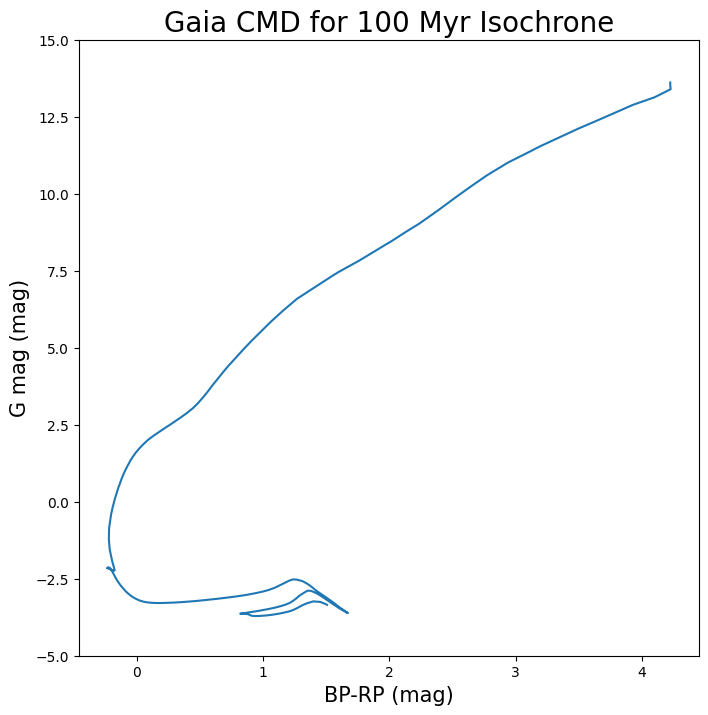

In [71]:
# Plot G vs BP-RP from isochrone_100Myr:
Gmag = isochrone_100Myr['Gmag'].data
BPRP = isochrone_100Myr['BP-RP'].data

# No need for all the fancy stuff, just use defaults:
# (I will assume since we are using defaults, to not use axis.scatter, and instead use plt.plot,)

plt.figure(figsize=(8,8))
plt.plot(BPRP, Gmag)

plt.title('Gaia CMD for 100 Myr Isochrone', fontsize=20)
plt.xlabel('BP-RP (mag)', fontsize=15)
plt.ylabel('G mag (mag)', fontsize=15)


plt.ylim(-5,15)  # note that since we didn't create figure and axis objects, to reset the y-limit, we use plt.ylim() NOT plt.set_ylim().

plt.show()

**Plot the CMD of a cluster from the list below and overlay isochrones on it until you find the best-fitting combination of age and amount of foreground interstellar extinction/reddening for that cluster**.



*   NGC_3532
*   NGC_2548
*   NGC_6811
*   NGC_752
*   Ruprecht_147



(0.0, 3.0)

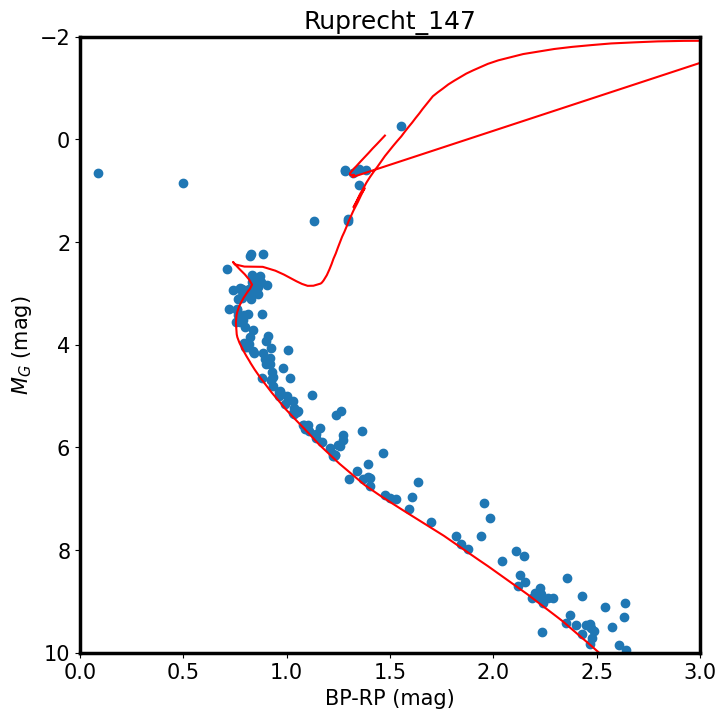

In [135]:
# Pick a cluster from the list above.
#Ruprecht_147

# Download its catalog
Ruprecht_147 = get_cluster('Ruprecht_147')

# Plot its CMD
Gmag = Ruprecht_147['Gmag'].data
BPRP = Ruprecht_147['BP-RP'].data

# remove out rows where parallax is zero or NaN
valid_rows = (Ruprecht_147['Parallax'] > 0) & ~np.isnan(Ruprecht_147['Parallax'])

# Extract Gmag and BP-RP values only for valid rows
Gmag = Ruprecht_147['Gmag'].data[valid_rows]
BPRP = Ruprecht_147['BP-RP'].data[valid_rows]
parallax_mas = Ruprecht_147['Parallax'].data[valid_rows]

distance_parsec = 1000 / parallax_mas
M_G = Gmag - 5 * (np.log10(distance_parsec) - 1)
figure, axis = plt.subplots(figsize=(8,8))
axis.scatter(BPRP, M_G, label='NGC_3532')

### Add axis labels & title
axis.set_xlabel('BP-RP (mag)', fontsize=15)
axis.set_ylabel('$M_G$ (mag)', fontsize=15)
axis.set_title('Ruprecht_147', fontsize=18)

# Make plot look nice
axis_border_width = 2.5
fontsize_axis_labels = 15
axis.tick_params(axis='both', which='major', labelsize=fontsize_axis_labels)
axis.spines['top'].set_linewidth(axis_border_width)
axis.spines['left'].set_linewidth(axis_border_width)
axis.spines['right'].set_linewidth(axis_border_width)
axis.spines['bottom'].set_linewidth(axis_border_width)

figure.show()

# Load the isochrone
Age = 3000.0 # Myr -- modify this number and Av until you get a good fit
Av = 0.28 # mag  -- modify this number and Age above until you get a good fit

# Overlay the isochrone model
# Vary the Age and Av interstellar extinction/reddening parameters to get a good fit.
my_isochrone = get_isochrone(Age, Av=Av)
axis.plot(my_isochrone['BP-RP'], my_isochrone['Gmag'], color='red', label=f'Isochrone {Age} Myr, Av={Av}')

# Add all the usual things (title, labels, limits, borders)
#axis.set_xlim(-1,4)
axis.set_ylim(10,-2) # Inverted y-axis
axis.set_xlim(0,3) # Inverted y-axis
# Save the figure
# Conclude the figure


Your plot should look like this: 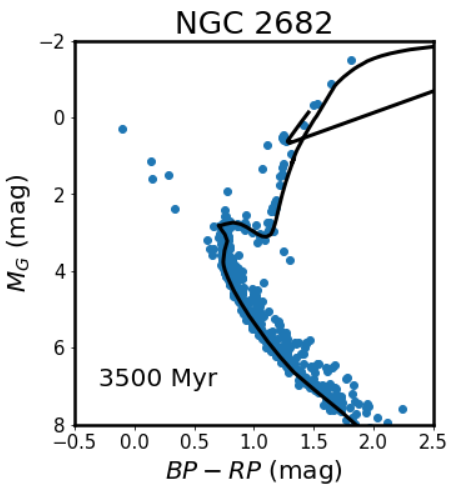

**Question**$-$In a few sentences, explain how you selected your best-fit isochrone.

> The age of the cluster was the most important feature I modfiying to get the the isochrone to fit. The Av value was just to hone in on the shape once the age parameter set the model roughly in place. I selected parameters that followed the main sequence well and the picked numbers that would give me an isochrone model that had a similair main sequence turn off point to that observed in my chosen cluster.

**Question**$-$Provide an estimate of the uncertainty on the age corresponding to your best-fit isochrone. One simple (but still quantitative!) way of approaching this is to bracket the best-fit isochrone with a slightly older and a slightly younger isochrone that still provide reasonable fits to your data.

> Anywhere from 2000 to 4000 Myr showed a decent fit of the data, so +/- around 1000 Myr is the uncertainity with the cluster and model parameters I have chose.

**Question**$-$In a few sentences, describe some ways in which you might improve your isochrone fit and age estimation.

> If there more data points from the cluster, then I could better know my chosen isochrone fit is accurate, lots of the rows in catalog of the cluster were missing either parallax or Gmag data. Besides more data, the functions that create the isochrone dont account for metallicity, which could provide a better isochrone fit, hypothetically. A qunatative apporach to this could be perhaps to use chi-squared analysis to minimize which isochrone age and Av reddning parameters results in the best fit.